In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fft

In [8]:
d = np.load(r"C:\Users\Fredric\Downloads\vars_out2k_full.npz")
tp = np.array(d["tp"])
list(d.keys())

['tp']

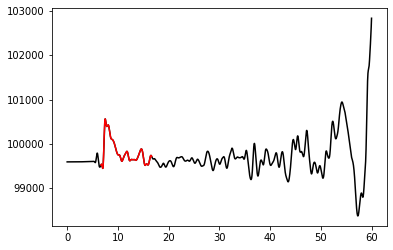

In [117]:
t = tp[:,0,2]
p = tp[:,1,2]
u = tp[:,2,2]
v = tp[:,3,2]

_i1 = 4000
_i2 = 10000
plt.plot(t, p, 'k')
plt.plot(t[_i1:_i2], p[_i1:_i2], 'r')

# plt.plot(t, u, 'k')
# plt.plot(t[_i1:_i2], u[_i1:_i2], 'r')

In [108]:
# plt.plot(t[_i1:_i2], ((p-p[0])*u)[_i1:_i2], 'r')
# plt.plot(t[_i1:_i2], (p-p[0])[_i1:_i2] / np.abs(p-p[0]).max(), 'r')
# plt.plot(t[_i1:_i2], u[_i1:_i2], 'r')
# plt.plot(t[_i1:_i2], v[_i1:_i2], 'r')


t_rise = 0.49333333333393625 s
1 / t_rise = 2.0270270270245496 Hz


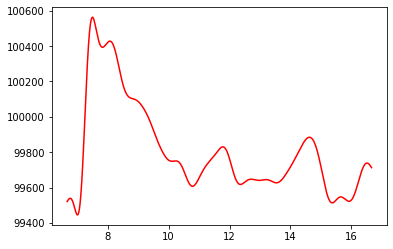

In [118]:
# Rise time identification

plt.plot(t[_i1:_i2], p[_i1:_i2], 'r')
t_rise = t[_i1:_i2][np.argmax(p[_i1:_i2])] - t[_i1:_i2][np.argmin(p[_i1:_i2])]
print(f't_rise = {t_rise} s')
print(f'1 / t_rise = {1 / t_rise} Hz')

Nyquist: 299.99999999963336 Hz
Approx spatial cutoff: 6.86 Hz


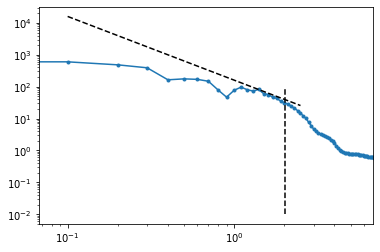

In [122]:
# Spatial cutoff value
f_spatial = 343 / 50

# Selected t, p values
t_loc = t[_i1:_i2]
p_loc = p[_i1:_i2]
u_loc = u[_i1:_i2]
v_loc = v[_i1:_i2]
signal = (p_loc - p_loc[0]) * (u_loc - u_loc[0]) # Power (for 0 degree horizontal)
# signal = p_loc * u_loc
N = p_loc.size
# Total time window
T = t[_i2] - t[_i1]
# Sampling dt
dt = t_loc[1] - t_loc[0]

f_nyquist = 0.5 / dt

# Complex FFT
z = scipy.fft.fft(signal)
# Magnitude
zmag = 2.0/N * np.abs(z[0:N//2])
# Frequency
f = scipy.fft.fftfreq(N, dt)[:N//2]
plt.loglog(f, zmag, '.-')
plt.loglog(f[1:26], 1.6e2/f[1:26]**2, 'k--')
plt.plot(1 / t_rise * np.array([1, 1]), np.array([1e-2, 1e2]), 'k--')

plt.xlim(right=np.minimum(f_nyquist, f_spatial))

print(f"Nyquist: {f_nyquist} Hz")
print(f"Approx spatial cutoff: {f_spatial} Hz")

In [165]:
def smoother(x, scale=0.01):
  ''' Returns one-sided smoothing u(x) of a step, such that
    1. u(x < -scale) = 0
    2. u(x >= 0) = 1.
    3. u smoothly interpolates from 0 to 1 in between.
  '''
  # Shift, scale, and clip to [-1, 0] to prevent exp overflow
  _x = np.clip(x / scale + 1, 0, 1)
  f0 = np.exp(-1/np.where(_x == 0, 1, _x))
  f1 = np.exp(-1/np.where(_x == 1, 1, 1-_x))
  # Return piecewise evaluation
  return np.where(_x >= 1, 1,
          np.where(_x <= 0, 0, 
            f0 / (f0 + f1)))

In [170]:
smoother(-.001)

array(0.99986211)

In [181]:
smoothed_jump(t_loc[int(0.4*t_loc.size)]), smoothed_jump(t_loc[int(0.5*t_loc.size)]),

(array(0.), array(1.))

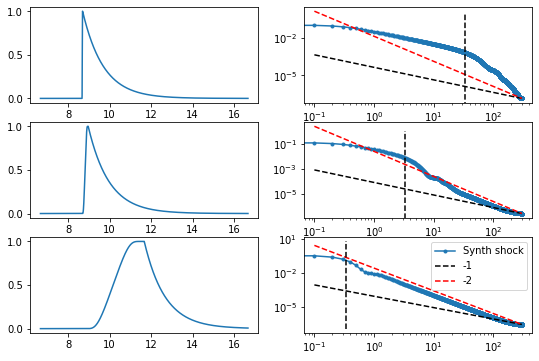

In [203]:
''' Synthetic shock '''

fig, ax = plt.subplots(3, 2, figsize=(9,6))
shock_scales = [.03, .3, 3]
for i in range(3):
  # Selected t, p values
  t_loc = t[_i1:_i2]
  jump_scale = shock_scales[i]
  t_jump_start = t_loc[int(0.2*t_loc.size)]
  t_jump_end = t_jump_start + jump_scale
  smoothed_jump = lambda t: \
    smoother(t - t_jump_start - jump_scale, scale=jump_scale)
  signal = np.piecewise(t_loc,
                        [t_loc < t_jump_start,
                        (t_loc >= t_jump_start) & (t_loc <= t_jump_end),
                        t_loc > t_jump_end,],
                        [lambda t: 0*t,
                        lambda t: smoother(t - t_jump_start - jump_scale, scale=jump_scale),
                        lambda t: np.exp(-(t - t_jump_end)), # Exponential tail
                        # lambda t: 1 - smoother(t - t_jump_end - jump_scale, scale=jump_scale),
                        ])
  # signal = p_loc * u_loc
  N = p_loc.size
  # Total time window
  T = t[_i2] - t[_i1]
  # Sampling dt
  dt = t_loc[1] - t_loc[0]

  f_nyquist = 0.5 / dt

  ax[i,0].plot(t_loc, signal)

  # Complex FFT
  z = scipy.fft.fft(signal**2)
  # Magnitude
  zmag = 2.0/N * np.abs(z[0:N//2])
  # Frequency
  f = scipy.fft.fftfreq(N, dt)[:N//2]
  ax[i,1].loglog(f, zmag, '.-')
  ax[i,1].loglog(f[1:] , (zmag[-1]) * f[-1] / f[1:], 'k--')
  ax[i,1].loglog(f[1:] , (zmag[-1]) * (f[-1] / f[1:])**2, 'r--')
  ax[i,1].plot(1 / jump_scale * np.array([1, 1]), plt.gca().get_ylim(), 'k--')
  plt.legend(["Synth shock", "-1", "-2"])

(0.0, 1.0)

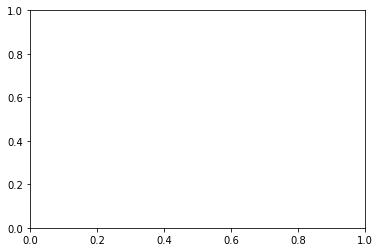

In [192]:
plt.gca().get_xlim()

In [45]:
t_loc[1] - t_loc[0]

0.0016666666666687036

In [43]:
# Spatial cutoff frequency
343 / 50

6.86

### Hydroacoustic nonlinearity

In [230]:
# Water propagation
beta = 3.5 # c.f. (gamma-1)/2

c0 = 1482
rho0 = 1000

# Pa pressure disturbance
dp = 1e5 / 10
# Velocity disturbance scale
du = dp / (rho0 * c0)

# Characteristic Rdot
Rdot = (10 / (4*np.pi/3))**(1/3) / (1/3)
print(Rdot)

u0 = Rdot # From order of magnitude Rdot
M0 = u0 / c0

4.009513852715927


In [243]:
# Nonlinear parameter
s = lambda k, x: beta * M0 * k * x
# Sine coefficients (n >= 1, s < 1)
Bn_interior = lambda n, s: 2 * scipy.special.jv(n,n * s) / (n * s)
# Asymptotic sine coefficients (n >= 1, s < 1)
Bn_asympt = lambda n, s: 2 / (n * (1 + s))

# Define mode (n >= 1)
mode = lambda n, x, omega, t: u0 * Bn_interior(n, s(omega / c0, x)) * np.sin(n * omega * t)


In [221]:
Bn_asympt(1, s(omega_source / c0, 90000))

0.07134115619282028

parameter s = beta * M * k * x = 0.009469162270246792 * 0.12718998597529527 = 0.0012043826163504845


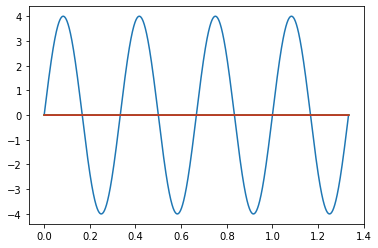

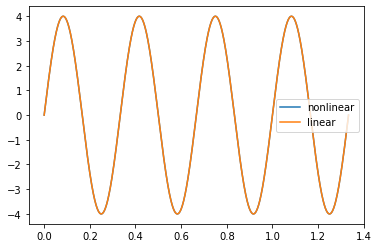

In [244]:
# Bubble peak frequency
f_source = 3.0
dist = 10

omega_source = 2 * np.pi * f_source
t_vec = np.linspace(0, 1/f_source*4, 3000)

print(f"parameter s = beta * M * k * x = {beta * M0} * {omega_source/c0 * dist} = {s(omega_source / c0, dist)}")

n_max = 25
modes = np.zeros((n_max, t_vec.size))
for n in range(1,n_max):
  modes[n] = mode(n, dist, omega_source, t_vec)

plt.figure()
for n in range(1,n_max):
  plt.plot(t_vec, modes[n])

plt.figure()
plt.plot(t_vec, np.sum(modes, axis=0))
plt.plot(t_vec, u0 * np.sin(omega_source * t_vec))
plt.legend(["nonlinear", "linear"])